In [1]:
% matplotlib inline
import pandas as pd

In [2]:
def aoi_group(area):
    area_type = area[0]
    types = {
        'f': 'face',
        'n': 'nowhere',
        'l': 'logo',
    }
    return types[area_type]

In [3]:
import os
dfs = []
dirname = 'fixations'
for filename in os.listdir(dirname):
    df = pd.read_csv(dirname+'/'+filename, sep='\t', index_col=False)
    df['AOI group'] = df['AOI'].map(aoi_group)
    df = df.drop(['Comments', 'Unnamed: 19', 'SlideNr', 'Trial Category'], axis=1)
    dfs.append(df)

In [4]:
all_df = pd.concat(dfs).reset_index(drop=True).drop('ID', axis=1)
all_df.columns = [name.replace(" ", "") for name in all_df.columns]
all_df.to_csv('all_fixations.txt', sep=';', index=False)


In [5]:
df = pd.read_csv('all_fixations.txt', sep=';')
df['LogoCategory'] = df['TrialName'].map(lambda s: s[0])
df['BackgroundCategory'] = df['TrialName'].map(lambda s: s[1])
df

,SubjectName,TrialID,TrialSequence,CountInTrial,StartTime,Length,PosX,PosY,SubjectCategory,Age,Sex,Handedness,TrialName,AOI,AOIgroup,LogoCategory,BackgroundCategory
0,S0902,0,0,1,46,304,"949,688720703125","394,373870849609",NaN,NaN,NaN,NaN,KF_001.jpg,nowhere,nowhere,K,F
1,S0902,0,0,2,380,206,"934,302001953125","107,774971008301",NaN,NaN,NaN,NaN,KF_001.jpg,fkf01,face,K,F
2,S0902,0,0,3,588,128,"982,473937988281","92,3215408325195",NaN,NaN,NaN,NaN,KF_001.jpg,fkf01,face,K,F
3,S0902,0,0,4,948,170,"1406,0791015625","775,459106445313",NaN,NaN,NaN,NaN,KF_001.jpg,nowhere,nowhere,K,F
4,S0902,0,0,5,1120,114,"1413,68481445313","797,598266601563",NaN,NaN,NaN,NaN,KF_001.jpg,nowhere,nowhere,K,F
5,S0902,0,0,6,1568,182,"1394,88903808594","182,397796630859",NaN,NaN,NaN,NaN,KF_001.jpg,nowhere,nowhere,K,F
6,S0902,0,0,7,1764,136,"1367,84350585938","92,5956497192383",NaN,NaN,NaN,NaN,KF_001.jpg,nowhere,nowhere,K,F
7,S0902,0,0,8,1938,252,"957,528137207031","110,806282043457",NaN,NaN,NaN,NaN,KF_001.jpg,fkf01,face,K,F
8,S0902,0,0,9,2394,128,"160,45231628418","668,501525878906",NaN,NaN,NaN,NaN,KF_001.jpg,nowhere,nowhere,K,F
9,S0902,0,0,10,2532,172,"131,34716796875","727,986206054688",NaN,NaN,NaN,NaN,KF_001.jpg,lkf1,logo,K,F


### Put the dataframes into SQL database to use SQL for querying

In [6]:
import sqlite3

conn = sqlite3.connect('eye_data.db')

df.to_sql('fixations', conn, if_exists='replace', index=False)

df2 = pd.read_csv('all_saccades.txt', sep=';')

df2['LogoCategory'] = df2['TrialName'].map(lambda s: s[0])
df2['BackgroundCategory'] = df2['TrialName'].map(lambda s: s[1])
df2.to_sql('saccades', conn, if_exists='replace', index=False)

### Number of fixations to each area of interest grouped by logo type and background type

In [6]:
pd.read_sql_query("select COUNT(*) AS Count, AOIgroup, LogoCategory, BackgroundCategory from fixations GROUP BY AOIgroup, LogoCategory, BackgroundCategory", conn)

,Count,AOIgroup,LogoCategory,BackgroundCategory
0,5916,face,K,F
1,5612,face,U,F
2,2911,logo,K,F
3,3817,logo,K,L
4,3857,logo,U,F
5,4825,logo,U,L
6,5208,nowhere,K,F
7,9550,nowhere,K,L
8,4686,nowhere,U,F
9,8584,nowhere,U,L


### Sum of fixations length to each area of interest grouped by logo type and background type

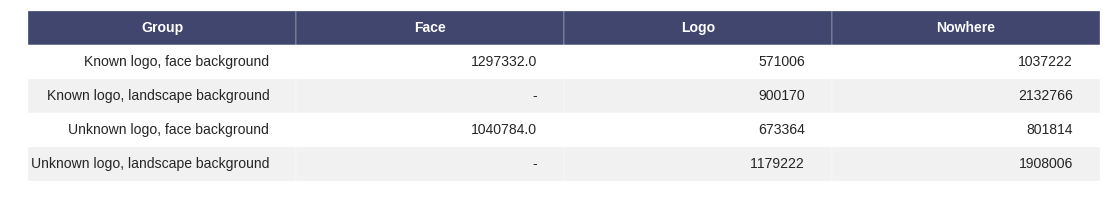

In [57]:
data = pd.read_sql_query("""
select SUM(Length) as TotalTime, AOIgroup, LogoCategory, BackgroundCategory
from fixations
WHERE TrialName NOT IN ({}) AND NOT SubjectName='S0702'
GROUP BY AOIgroup, LogoCategory, BackgroundCategory""".format(placeholders), conn, params=BAD_TRIALS)
d = {
    'KF': 'Known logo, face background',
    'UL': 'Unknown logo, landscape background',
    'KL': 'Known logo, landscape background',
    'UF': 'Unknown logo, face background'
}
data['Group'] = (data['LogoCategory'] + data['BackgroundCategory']).apply(lambda text: d[text])
data = data.drop(['LogoCategory', 'BackgroundCategory'], axis=1)
data['Group'] = data['Group'].astype(str)
pivoted = data.pivot(index='Group', columns='AOIgroup')

pivoted.columns = ['Face', 'Logo', 'Nowhere']
pivoted = pivoted.fillna(value='-', downcast='infer')
pivoted['Face'] = pivoted['Face'].astype(str)
pivoted['Group'] = pivoted.index
#data.groupby('Group').cumcount()
pivoted = pivoted[[3, 0, 1, 2]]
ax = render_mpl_table(pivoted, header_columns=0, col_width=4.8)
ax.get_figure().savefig('fixations.png', bbox_inches='tight')

In [84]:
pivoted.index

Index([u'Known logo, face background', u'Known logo, landscape background',
       u'Unknown logo, face background',
       u'Unknown logo, landscape background'],
      dtype='object', name=u'Group')

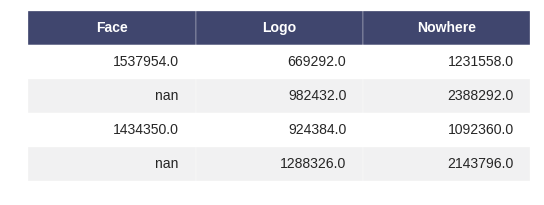

### Sum of fixation length to different areas of interest

In [11]:
pd.read_sql_query("select SUM(Length), AOIgroup from fixations GROUP BY AOIgroup", conn)

,SUM(Length),AOIgroup
0,2972304,face
1,3864434,logo
2,6856006,nowhere


### Sum of fixation length to different areas of interest grouped by logo type

In [16]:
pd.read_sql_query("select SUM(Length), AOIgroup, LogoCategory from fixations GROUP BY AOIgroup, LogoCategory", conn)

,SUM(Length),AOIgroup,LogoCategory
0,1537954,face,K
1,1434350,face,U
2,1651724,logo,K
3,2212710,logo,U
4,3619850,nowhere,K
5,3236156,nowhere,U


### Number  of first saccades grouped by background and logo types

In [17]:
pd.read_sql_query("""
select COUNT(*), AOIgroup, LogoCategory, BackgroundCategory
from saccades
WHERE CountInTrial=1 AND TrialSe
GROUP BY AOIgroup, LogoCategory, BackgroundCategory""", conn)

,COUNT(*),AOIgroup,LogoCategory,BackgroundCategory
0,673,face,K,F
1,725,face,U,F
2,144,logo,K,F
3,574,logo,K,L
4,112,logo,U,F
5,593,logo,U,L
6,182,nowhere,K,F
7,426,nowhere,K,L
8,163,nowhere,U,F
9,407,nowhere,U,L


### Number of first saccades to different areas of interest

In [14]:
pd.read_sql_query("""
select COUNT(*), AOIgroup
from saccades
WHERE CountInTrial=1
GROUP BY AOIgroup""", conn)

,COUNT(*),AOIgroup
0,1398,face
1,1423,logo
2,1178,nowhere


### Number of first saccades to different areas of interest grouped by background type

In [15]:
pd.read_sql_query("""
select COUNT(*), AOIgroup, BackgroundCategory
from saccades
WHERE CountInTrial=1
GROUP BY AOIgroup, BackgroundCategory""", conn)

,COUNT(*),AOIgroup,BackgroundCategory
0,1398,face,F
1,256,logo,F
2,1167,logo,L
3,345,nowhere,F
4,833,nowhere,L


### Number of all saccades to different areas of interest grouped by logo category and background type

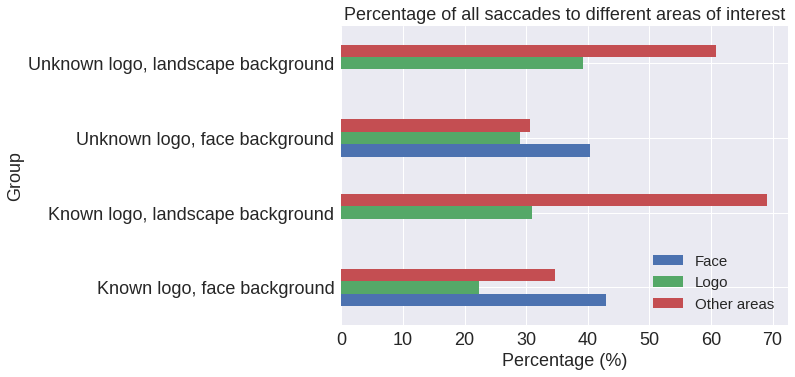

In [124]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import six
data = pd.read_sql_query("""
select COUNT(*) AS Count, AOIgroup, LogoCategory, BackgroundCategory
from saccades
WHERE TrialName NOT IN ({}) AND NOT SubjectName='S0702'
GROUP BY AOIgroup, LogoCategory, BackgroundCategory""".format(placeholders), conn, params=BAD_TRIALS)


def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

data['Group'] = (data['LogoCategory'] + data['BackgroundCategory']).apply(lambda text: d[text])
data = data.drop(['LogoCategory', 'BackgroundCategory'], axis=1)
data['Group'] = data['Group'].astype(str)
pivoted = data.pivot(index='Group', columns='AOIgroup')

pivoted.columns = ['Face', 'Logo', 'Other areas']
pivoted
pivoted.fillna(value=0, inplace=True)
pivoted = pivoted.div(pivoted.sum(axis=1)/100, axis=0)
ax = pivoted.plot.barh(x=pivoted.index, y=['Face', 'Logo', 'Other areas'], title='Percentage of all saccades to different areas of interest')
ax.set_xlabel('Percentage (%)')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
ax.get_figure().savefig('all_saccades.png', bbox_inches='tight')

In [97]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
import matplotlib.pyplot as plt
plt.rc('legend',**{'fontsize':15})
plt.rc('font', **{'size': 18})

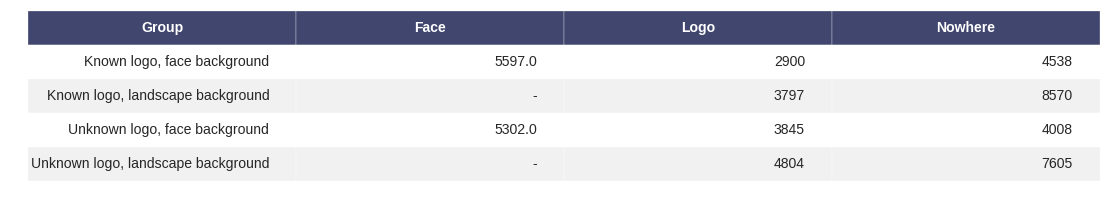

In [118]:
pivoted = pivoted.fillna(value='-', downcast='infer')
pivoted['Face'] = pivoted['Face'].astype(str)
pivoted['Group'] = pivoted.index
#data.groupby('Group').cumcount()
pivoted = pivoted[[3, 0, 1, 2]]
ax = render_mpl_table(pivoted, header_columns=0, col_width=4.8)

#ax = render_mpl_table(pivoted, header_columns=0, col_width=3.0)
ax.get_figure().savefig('saccades.png', bbox_inches='tight')

In [38]:
df4 = pd.read_sql_query("""
select COUNT(*), AOIgroup, LogoCategory, BackgroundCategory
from saccades
WHERE AOIGroup='logo'
GROUP BY AOIgroup, LogoCategory, BackgroundCategory""", conn)

df4

,COUNT(*),AOIgroup,LogoCategory,BackgroundCategory
0,2900,logo,K,F
1,3797,logo,K,L
2,3845,logo,U,F
3,4804,logo,U,L


In [ ]:
plt.bar()

In [123]:
df3 = pd.read_sql_query("""
select COUNT(*) AS Count, AOIgroup, LogoCategory, BackgroundCategory
from saccades
WHERE countInTrial=1 AND TrialName NOT IN ({}) AND NOT SubjectName='S0702'
GROUP BY AOIgroup, LogoCategory, BackgroundCategory""".format(placeholders), conn, params=BAD_TRIALS)

In [34]:
BAD_TRIALS = """KF_049
KF_051
KF_078
KF_082
KF_092
KF_098
KL_062
KL_064
KL_075
KL_078
KL_094
UF_017
UF_019
UF_021
UF_029
UF_031
UF_041
UF_042
UF_050
UF_061
UF_067
UF_071
UF_072
UF_073
UF_074
UF_075
UF_077
UF_078
UF_079
UF_080
UL_061
UL_062
UL_063
UL_064
UL_065
UL_066
UL_067
UL_068
UL_069
UL_071
UL_072
UL_074
UL_075
UL_076
UL_077
UL_078
UL_080
UL_081
UL_083""".split('\n')

BAD_TRIALS = [name + '.jpg' for name in BAD_TRIALS]

In [121]:
d = {
    'KF': 'Known logo, face background',
    'UL': 'Unknown logo, landscape background',
    'KL': 'Known logo, landscape background',
    'UF': 'Unknown logo, face background'
}
df5['Group'] = (df5['LogoCategory'] + df5['BackgroundCategory']).apply(lambda text: d[text])

data = df5

data = data.drop(['LogoCategory', 'BackgroundCategory'], axis=1)
data['Group'] = data['Group'].astype(str)
pivoted = data.pivot(index='Group', columns='AOIgroup')

pivoted.columns = ['Face', 'Logo', 'Other areas']
pivoted
pivoted.fillna(value=0, inplace=True)
pivoted = pivoted.div(pivoted.sum(axis=1)/100, axis=0)
ax = pivoted.plot.barh(x=pivoted.index, y=['Face', 'Logo', 'Other areas'], title='Percentage of all saccades to different areas of interest')
ax.set_xlabel('Percentage (%)')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)

all_saccades = df5.plot(x='Group', y=['Count', kind='barh', title='Number of all saccades to logos by background category and logo type')
all_saccades.get_figure().savefig('all_saccades.png', bbox_inches='tight')

SyntaxError: invalid syntax (<ipython-input-121-2115ce787374>, line 10)

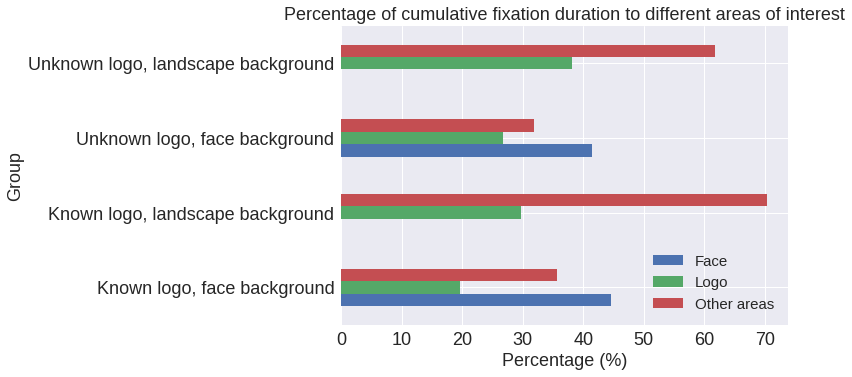

In [125]:
placeholders = ', '.join('?' for item in BAD_TRIALS)
df6 = pd.read_sql_query("""
select SUM(Length) AS Duration, AOIgroup, LogoCategory, BackgroundCategory
from fixations
WHERE TrialName NOT IN ({}) AND NOT SubjectName='S0702'
GROUP BY AOIgroup, LogoCategory, BackgroundCategory""".format(placeholders), conn, params=BAD_TRIALS)
df6['Group'] = (df6['LogoCategory'] + df6['BackgroundCategory']).apply(lambda text: d[text])

#fixation_length = df6.plot(x='Group', y='Duration', kind='barh', title='Length of logo fixations by background category and logo type')
#fixation_length.get_figure().savefig('fixation_length.png', bbox_inches='tight')
data = df6
data = data.drop(['LogoCategory', 'BackgroundCategory'], axis=1)
data['Group'] = data['Group'].astype(str)
pivoted = data.pivot(index='Group', columns='AOIgroup')

pivoted.columns = ['Face', 'Logo', 'Other areas']
pivoted.fillna(value=0, inplace=True)
pivoted = pivoted.div(pivoted.sum(axis=1)/100, axis=0)
ax = pivoted.plot.barh(x=pivoted.index, y=['Face', 'Logo', 'Other areas'], title='Percentage of cumulative fixation duration to different areas of interest')
ax.set_xlabel('Percentage (%)')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
ax.get_figure().savefig('fixation_length.png', bbox_inches='tight')

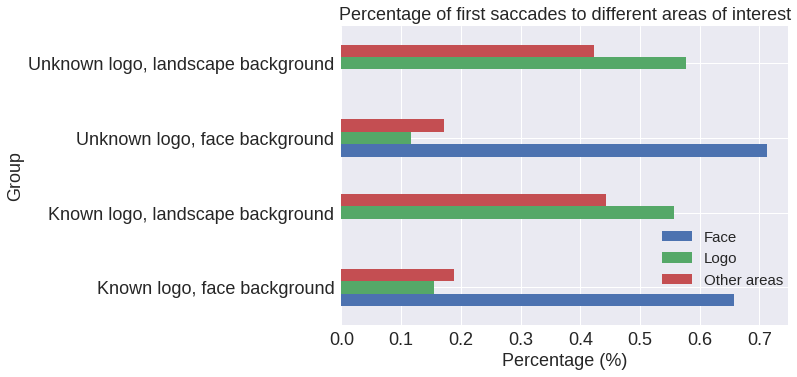

In [117]:
d = {
    'KF': 'Known logo, face background',
    'UL': 'Unknown logo, landscape background',
    'KL': 'Known logo, landscape background',
    'UF': 'Unknown logo, face background'
}
df3['Group'] = (df3['LogoCategory'] + df3['BackgroundCategory']).apply(lambda text: d[text])

data = df3
data = data.drop(['LogoCategory', 'BackgroundCategory'], axis=1)
data['Group'] = data['Group'].astype(str)
pivoted = data.pivot(index='Group', columns='AOIgroup')

pivoted.columns = ['Face', 'Logo', 'Other areas']
pivoted.fillna(value=0, inplace=True)
pivoted = pivoted.div(pivoted.sum(axis=1), axis=0)
#pivoted.columns.name = 'Areas of interest'
ax = pivoted.plot.barh(x=pivoted.index, y=['Face', 'Logo', 'Other areas'], title='Percentage of first saccades to different areas of interest')
ax.set_xlabel('Percentage (%)')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
ax.legend(loc='lower right', bbox_to_anchor=(1.02, 0.08))
ax.get_figure().savefig('first_saccades.png', bbox_inches='tight')

#first_saccades = df3.plot(x='Group', y='Count', kind='barh', title='Number of first saccades to logos by background category and logo type')
#first_saccades.get_figure().savefig('first_saccades.png', bbox_inches='tight')

In [27]:
df4['Group'] = (df4['LogoCategory'] + df4['BackgroundCategory']).apply(lambda text: d[text])
all_saccades = df4.plot(x='Group', y='COUNT(*)', kind='barh', title='Number of all saccades to logos by background category and logo type')
all_saccades.get_figure().savefig('all_saccades.png')

NameError: name 'df4' is not defined

In [15]:
from scipy.stats import ttest_ind, ttest_ind_from_stats
query_k = "\
select COUNT(*) \
from saccades \
WHERE CountInTrial=1 AND AOIgroup = '{}' AND LogoCategory = '{}' \
GROUP BY SubjectName".format("logo","K")

query_u = "\
select COUNT(*) \
from saccades \
WHERE CountInTrial=1 AND AOIgroup = '{}' AND LogoCategory = '{}' \
GROUP BY SubjectName".format("logo","U")

first_saccades_k = pd.read_sql_query(query_k, conn)
first_saccades_u = pd.read_sql_query(query_u, conn)

In [14]:
first_saccades_k

,COUNT(*)
0,76
1,51
2,55
3,80
4,87
5,46
6,103
7,40
8,88
9,92
